In [246]:
import numpy as np
from collections import Counter
# 计算熵
def entropy(x):
    x = np.asarray(x)
    length = x.shape[0]
    counter = Counter(x)
    for key,value in counter.items():
        counter[key] = 1.0 * value / length
    ans = 0 
    for value in counter.values():
        ans -= value * np.log(value)
    return ans

In [247]:
entropy([1,2,2,1,3,12,3])

1.351783994289646

In [248]:
# 计算条件熵H(Y|X)
def cond_entropy(x,y):
    x = np.asarray(x)
    n_samples = len(x)
    y = np.asarray(y)
    counter = Counter(x)
    ret = 0
    for x_value,x_count in counter.items():
        sample_index = np.argwhere(x == x_value).reshape(-1)
        y_i = y[sample_index]
        p_x_i = x_count / n_samples
        ret += p_x_i * entropy(y_i)
    return ret
        
        

In [249]:
cond_entropy([1,2,3,1,2,3,1,2,1,2,3],[2,2,3,23,1,3,1,2,1,2,3])

0.5825657874395368

In [250]:
# 互信息
def multi_info(x,y):
    return entropy(y) - entropy(x,y)


# 决策树之C4.5和ID3算法

In [251]:

import utils
import copy        
        
class DecisionTreeClassifier(object):
    # 节点类
    class Node(object):
        def __init__(self,feature_index: int = None,target_distribution: dict = None,weight_distribution: dict = None,
                     children_nodes: dict = None,num_sample: int = None,features:set = None):
            self.feature_index = feature_index
            self.target_distribution = target_distribution
            self.weight_distribution = weight_distribution
            self.children_nodes = children_nodes
            self.num_sample = num_sample
            self.features = features
    
    def __init__(self,criterion = 'C4.5',max_depth = None,min_sample_split = 2,min_sample_leaf = 1,
                 min_impurity_decrease=0,max_bins = 10):
        self.criterion = criterion
        # c4.5使用信息增益比作为准则对属性进行选择
        if self.criterion == 'C4.5':
            # 设置划分函数为信息增益比
            self.criterion_func = utils.info_gain_rate
        elif self.criterion == 'ID3':
            self.criterion_func = utils.muti_info
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.min_sample_leaf = min_sample_leaf
        # 当信息的增益小于这个值时不再进行划分
        self.min_impurity_decrease = min_impurity_decrease
        
        # 对属性进行离散化的封装器
        self.dataBinWrapper = utils.DataBinWrapper(max_bin=max_bins)
        
        self.sample_weight = None
        self.root_node : self.Node = None
    
    # 根据给定的数据(x,y)从当前节点current_node建树，样本的权重列表为sample_weight
    def _build_tree(self,current_depth,current_node: Node,x,y,sample_weight):
        n_samples , n_features = x.shape
        # 统计在当前节点y的概率分布和权重分布
        target_distribution = {}
        weight_distribution = {}
        for index, y_class in enumerate(y):
            if target_distribution.get(y_class) == None:
                target_distribution[y_class] = 0
                weight_distribution[y_class] = []
            target_distribution[y_class] += 1
            weight_distribution[y_class].append(sample_weight[index])
        
        for y_class,value in target_distribution.items():
            target_distribution[y_class] /= n_samples
            weight_distribution[y_class] = np.mean(weight_distribution[y_class])

        current_node.num_sample = n_samples
        current_node.target_distribution = target_distribution
        current_node.weight_distribution = weight_distribution
        
        # 样本数量不足以划分成子树
        if current_node.num_sample < self.min_sample_split:
            return 
        
        # 没有可以划分的属性
        if len(current_node.features) == 0:
            return 
        
        # 只有一个类别，不进行划分
        if len(current_node.target_distribution) <= 1:
            return
        
        if self.max_depth != None and current_depth > self.max_depth :
            return 
        
        # 找到信息增益比最大的特征，并且以该特征划分数据集
        best_index = None
        best_criterion_value = 0
        # for index in range(n_features):
        for index in current_node.features:
            criterion_value = self.criterion_func(x[:,index],y,sample_weight)
            if criterion_value > best_criterion_value:
                best_criterion_value = criterion_value
                best_index = index
            
        if best_index == None:
            return 
        
        if best_criterion_value < self.min_impurity_decrease:
            return 
        
        current_node.feature_index = best_index
        current_node.children_nodes = {}
        selected_x = x[:,best_index]
        # 检索每一个值，划分成子树
        # 对每一棵子树都递归建树
        for value in set(selected_x):
            seletcted_index = np.where(selected_x == value)
            # 样本数量太少，不能生成一颗子树
            if len(seletcted_index[0]) < self.min_sample_leaf:
                return 
            child_node = self.Node()
            # 将属性集合减去已经划分的属性
            set_of_child = copy.deepcopy(current_node.features) - set([best_index])
            child_node.features = set_of_child
            current_node.children_nodes[value] = child_node
            self._build_tree(current_depth+1,child_node,x[seletcted_index],y[seletcted_index],sample_weight[seletcted_index])
    
    def fit(self,x,y,sample_weight=None):
        n_samples,n_features = x.shape
        if sample_weight is None:
            self.sample_weight = np.array([1.0] * n_samples)
        else:
            self.sample_weight = sample_weight
        self.dataBinWrapper.fit(x)
        
        self.root_node = self.Node()
        # 设置初始的属性集合Ag
        self.root_node.features = set(range(n_features))
        
        self._build_tree(1,self.root_node,self.dataBinWrapper.transform(x),y,self.sample_weight)
    
    
    # 返回概率分布P(y)
    def _search_node(self,current_node:Node,x,class_num):
        # 当前节点是叶子结点或者子树中没有当前x的取值的划分，结束搜索
        if current_node.feature_index is None or current_node.children_nodes is None or \
            len(current_node.children_nodes) == 0 or current_node.children_nodes.get(
                x[current_node.feature_index]) is None:
            result = []
            total_prob = 0
            for index in range(class_num):
                prob = current_node.target_distribution.get(index,0) * current_node.weight_distribution.get(index,1.0)
                result.append(prob)
                total_prob += prob
            # 将概率归一化
            for index in range(class_num):
                result[index] /= total_prob
            return result
            
        else :
            return self._search_node(current_node.children_nodes[x[current_node.feature_index]],x,class_num)


    def predict_prob(self,X):
        ret = []
        # 对带预测数据各个维度进行分箱操作
        X = self.dataBinWrapper.transform(X)
        class_num = len(self.root_node.target_distribution)
        for index in range(X.shape[0]):
            ret.append(self._search_node(self.root_node,X[index],class_num))
        return np.asarray(ret)

    def predict(self,X):
        return np.argmax(self.predict_prob(X),axis=1)
    
    # 对完全树进行剪枝
    def _prune_node(self,current_node: Node,alpha):
        # 存在叶子结点，对叶子节点进行剪枝
        if current_node.children_nodes is not None and len(current_node.children_nodes) > 0:
            for child_node in current_node.children_nodes.values():
                self._prune_node(child_node,alpha)
                
        # 对子树剪枝完毕之后对当前节点进行剪枝
        if current_node.children_nodes is not None and len(current_node.children_nodes) > 0:
            # 只在叶子结点和它的父节点之间进行剪枝
            for child_node in current_node.children_nodes.values():
                if child_node.children_nodes is not None and len(child_node.children_nodes) > 0:
                    return 
            # 当前节点和它的子节点之间可以尝试剪枝
            # 剪枝前的损失 = 树的结构损失 + 预测误差（熵)
            pre_prune_value = alpha * len(current_node.children_nodes)
            for child_node in current_node.children_nodes.values():
                # key:类别，value：概率
                for key,value in child_node.target_distribution.items():
                    pre_prune_value += - child_node.num_sample * value * np.log(value) * \
                        child_node.weight_distribution.get(key,1.0)
            after_prune_value = alpha 
            for key ,value in current_node.target_distribution.items():
                after_prune_value += - current_node.num_sample * value * np.log(value) * \
                    current_node.weight_distribution[key]
            
            # 如果剪枝之后的损失更加小，则剪枝
            if after_prune_value < pre_prune_value :
                current_node.children_nodes = None
                current_node.feature_index = None
                
    def prune(self,alpha=0.01):
        self._prune_node(self.root_node,alpha)

In [252]:
#造伪数据
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=200, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=0.5,random_state=21)

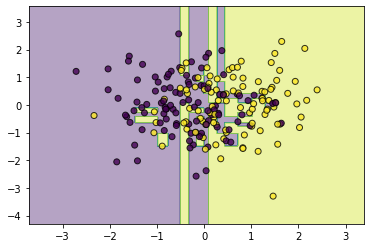

In [253]:
#训练查看效果
tree = DecisionTreeClassifier(max_bins=15,criterion='C4.5')
tree.fit(data, target)
utils.plot_decision_function(data, target, tree)

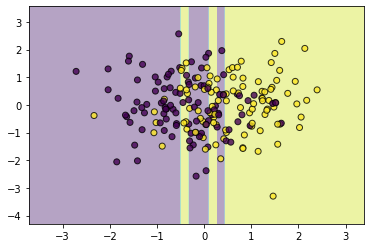

In [254]:
# 对决策树进行剪枝，查看剪枝的效果
tree.prune(alpha=1.0)
utils.plot_decision_function(data, target, tree)

# 决策树 CART算法

In [255]:
# CART分类树
import os
os.chdir('../')
import utils
"""
CART分类树的实现，代码封装到ml_models.tree模块
"""
class CARTClassifier(object):
    class Node(object):
        """
        树节点，用于存储节点信息以及关联子节点
        """

        def __init__(self, feature_index: int = None, feature_value=None, target_distribute: dict = None,
                     weight_distribute: dict = None,
                     left_child_node=None, right_child_node=None, num_sample: int = None):
            """
            :param feature_index: 特征id
            :param feature_value: 特征取值
            :param target_distribute: 目标分布
            :param weight_distribute:权重分布
            :param left_child_node: 左孩子结点
            :param right_child_node: 右孩子结点
            :param num_sample:样本量
            """
            self.feature_index = feature_index
            self.feature_value = feature_value
            self.target_distribute = target_distribute
            self.weight_distribute = weight_distribute
            self.left_child_node = left_child_node
            self.right_child_node = right_child_node
            self.num_sample = num_sample

    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 min_impurity_decrease=0, max_bins=10):
        """
        :param criterion:划分标准，默认为gini,另外entropy表示用信息增益比
        :param max_depth:树的最大深度
        :param min_samples_split:当对一个内部结点划分时，要求该结点上的最小样本数，默认为2
        :param min_samples_leaf:设置叶子结点上的最小样本数，默认为1
        :param min_impurity_decrease:打算划分一个内部结点时，只有当划分后不纯度(可以用criterion参数指定的度量来描述)减少值不小于该参数指定的值，才会对该结点进行划分，默认值为0
        """
        self.criterion = criterion
        if criterion == 'gini':
            # 使用基尼指数评价一个特征对信息的影响，基尼指数越低特征越能将数据分类，也就是越有效
            self.criterion_func = utils.gini_D_conditioned_A
        else:
            self.criterion_func = utils.info_gain_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease

        self.root_node: self.Node = None
        self.dbw = utils.DataBinWrapper(max_bins)

    def _build_tree(self, current_depth, current_node: Node, x, y, sample_weight):
        """
        递归进行特征选择，构建树
        :param x:
        :param y:
        :param sample_weight:
        :return:
        """
        rows, cols = x.shape
        # 计算y分布以及其权重分布
        target_distribute = {}
        weight_distribute = {}
        for index, tmp_value in enumerate(y):
            if tmp_value not in target_distribute:
                target_distribute[tmp_value] = 0.0
                weight_distribute[tmp_value] = []
            target_distribute[tmp_value] += 1.0
            weight_distribute[tmp_value].append(sample_weight[index])
        for key, value in target_distribute.items():
            target_distribute[key] = value / rows
            weight_distribute[key] = np.mean(weight_distribute[key])
        current_node.target_distribute = target_distribute
        current_node.weight_distribute = weight_distribute
        current_node.num_sample = rows
        # 判断停止切分的条件
        # 该节点的数据只属于一个类别或者
        # 样本的数量已经不适合再进行划分
        # 或者深度已经到达了极限
        if len(target_distribute) <= 1:
            return

        if rows < self.min_samples_split:
            return

        if self.max_depth is not None and current_depth > self.max_depth:
            return

        # 寻找最佳的特征以及取值
        # 找到最小的基尼指数（对应于一个特征和其取值
        best_index = None
        best_index_value = None
        best_criterion_value = np.Infinity
        for index in range(0, cols):
            if len(set(x[:,index]))==1: continue
            for index_value in set(x[:, index]):
                criterion_value = self.criterion_func(x, y,index_value, sample_weight)
                if criterion_value < best_criterion_value:
                    best_criterion_value = criterion_value
                    best_index = index
                    best_index_value = index_value
                    
            
        # 如果criterion_value减少不够则停止
        if best_index is None:
            return
        if best_criterion_value <= self.min_impurity_decrease:
            return
        # 切分
        current_node.feature_index = best_index
        current_node.feature_value = best_index_value
        selected_x = x[:, best_index]

        # 创建左孩子结点
        left_selected_index = np.where(selected_x == best_index_value)
        # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
        if len(left_selected_index[0]) >= self.min_samples_leaf:
            left_child_node = self.Node()
            current_node.left_child_node = left_child_node
            self._build_tree(current_depth + 1, left_child_node, x[left_selected_index], y[left_selected_index],
                             sample_weight[left_selected_index])
        # 创建右孩子结点
        right_selected_index = np.where(selected_x != best_index_value)
        # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
        if len(right_selected_index[0]) >= self.min_samples_leaf:
            right_child_node = self.Node()
            current_node.right_child_node = right_child_node
            self._build_tree(current_depth + 1, right_child_node, x[right_selected_index], y[right_selected_index],
                             sample_weight[right_selected_index])

    def fit(self, x, y, sample_weight=None):
        # check sample_weight
        n_sample = x.shape[0]
        if sample_weight is None:
            sample_weight = np.asarray([1.0] * n_sample)
        # check sample_weight
        if len(sample_weight) != n_sample:
            raise Exception('sample_weight size error:', len(sample_weight))

        # 构建空的根节点
        self.root_node = self.Node()

        # 对x分箱
        self.dbw.fit(x)

        # 递归构建树
        self._build_tree(1, self.root_node, self.dbw.transform(x), y, sample_weight)

    # 检索叶子节点的结果
    def _search_node(self, current_node: Node, x, class_num):
        if current_node.left_child_node is not None and x[current_node.feature_index] == current_node.feature_value:
            return self._search_node(current_node.left_child_node, x, class_num)
        elif current_node.right_child_node is not None and x[current_node.feature_index] != current_node.feature_value:
            return self._search_node(current_node.right_child_node, x, class_num)
        else:
            result = []
            total_value = 0.0
            for index in range(0, class_num):
                value = current_node.target_distribute.get(index, 0) * current_node.weight_distribute.get(index, 1.0)
                result.append(value)
                total_value += value
            # 归一化
            for index in range(0, class_num):
                result[index] = result[index] / total_value
            return result

    def predict_proba(self, x):
        # 计算结果概率分布
        x = self.dbw.transform(x)
        rows = x.shape[0]
        results = []
        class_num = len(self.root_node.target_distribute)
        for row in range(0, rows):
            results.append(self._search_node(self.root_node, x[row], class_num))
        return np.asarray(results)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def _prune_node(self, current_node: Node, alpha):
        # 如果有子结点,先对子结点部分剪枝
        if current_node.left_child_node is not None:
            self._prune_node(current_node.left_child_node, alpha)
        if current_node.right_child_node is not None:
            self._prune_node(current_node.right_child_node, alpha)
        # 再尝试对当前结点剪枝
        if current_node.left_child_node is not None or current_node.right_child_node is not None:
            # 避免跳层剪枝
            for child_node in [current_node.left_child_node, current_node.right_child_node]:
                # 当前剪枝的层必须是叶子结点的层
                if child_node.left_child_node is not None or child_node.right_child_node is not None:
                    return
            # 计算剪枝的前的损失值
            # 使用节点上的分类熵作为损失
            pre_prune_value = 0
            if current_node.left_child_node is not None:
                pre_prune_value += alpha
                for key,value in current_node.left_child_node.target_distribute.items():
                    pre_prune_value += - current_node.left_child_node.num_sample * value * np.log(
                    value ) * current_node.left_child_node.weight_distribute.get(key,1.0)
            if current_node.right_child_node is not None:
                pre_prune_value += alpha
                for key,value in current_node.right_child_node.target_distribute.items():
                    pre_prune_value += - current_node.right_child_node.num_sample * value * np.log(
                    value ) * current_node.right_child_node.weight_distribute.get(key,1.0)
            
            # 计算剪枝后的损失值
            after_prune_value = alpha
            for key, value in current_node.target_distribute.items():
                after_prune_value += -1 * current_node.num_sample * value * np.log(
                    value) * current_node.weight_distribute.get(key, 1.0)

            if after_prune_value <= pre_prune_value:
                # 剪枝操作
                current_node.left_child_node = None
                current_node.right_child_node = None
                current_node.feature_index = None
                current_node.feature_value = None

    def prune(self, alpha=0.01):
        """
        决策树剪枝 C(T)+alpha*|T|
        :param alpha:
        :return:
        """
        # 递归剪枝
        self._prune_node(self.root_node, alpha)

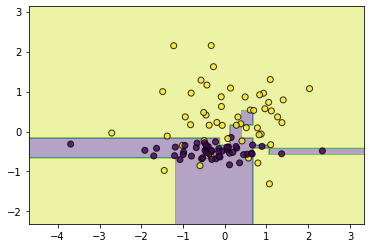

In [256]:
#造伪数据
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state = 6)
#训练并查看效果
tree = CARTClassifier()
tree.fit(data, target)
utils.plot_decision_function(data, target, tree)

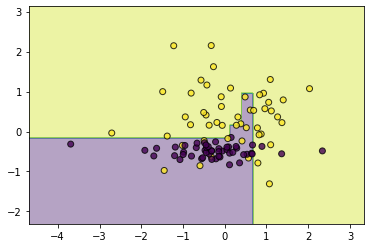

In [257]:
tree.prune(alpha=5)
utils.plot_decision_function(data,target,tree)

In [258]:

# CART最小二乘回归树
class CARTRegressor(object):
    class Node(object):
        """
        树节点，用于存储节点信息以及关联子节点
        """

        def __init__(self, feature_index: int = None, feature_value=None, y_hat=None, square_error=None,
                     left_child_node=None, right_child_node=None, num_sample: int = None):
            """
            :param feature_index: 特征id
            :param feature_value: 特征取值
            :param y_hat: 预测值
            :param square_error: 当前结点的平方误差
            :param left_child_node: 左孩子结点
            :param right_child_node: 右孩子结点
            :param num_sample:样本量
            """
            self.feature_index = feature_index
            self.feature_value = feature_value
            self.y_hat = y_hat
            self.square_error = square_error
            self.left_child_node = left_child_node
            self.right_child_node = right_child_node
            self.num_sample = num_sample

    def __init__(self, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_std=1e-3,
                 min_impurity_decrease=0, max_bins=10):
        """
        :param criterion:划分标准，目前仅有平方误差
        :param max_depth:树的最大深度
        :param min_samples_split:当对一个内部结点划分时，要求该结点上的最小样本数，默认为2
        :param min_std:最小的标准差
        :param min_samples_leaf:设置叶子结点上的最小样本数，默认为1
        :param min_impurity_decrease:打算划分一个内部结点时，只有当划分后不纯度(可以用criterion参数指定的度量来描述)减少值不小于该参数指定的值，才会对该结点进行划分，默认值为0
        """
        self.criterion = criterion
        if criterion == 'mse':
            self.criterion_func = utils.square_error_gain
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_std = min_std
        self.min_impurity_decrease = min_impurity_decrease

        self.root_node: self.Node = None
        self.dbw = utils.DataBinWrapper(max_bins)

    def _build_tree(self, current_depth, current_node: Node, x, y, sample_weight):
        """
        递归进行特征选择，构建树
        :param x:
        :param y:
        :param sample_weight:
        :return:
        """
        rows, cols = x.shape
        # 计算当前y的加权平均值
        current_node.y_hat = np.dot(sample_weight / np.sum(sample_weight), y)
        current_node.num_sample = rows
        # 判断停止切分的条件
        current_node.square_error = np.sum(np.power(y - np.mean(y),2))
        # 查看当前数据的平均平凡误差是否小于阈值
        if np.sqrt(current_node.square_error / rows) <= self.min_std:
            return

        if rows < self.min_samples_split:
            return

        if self.max_depth is not None and current_depth > self.max_depth:
            return

        # 寻找最佳的特征以及取值
        best_index = None
        best_index_value = None
        best_criterion_value = np.Infinity
        # 查找最小的划分点(j,s)
        for index in range(0, cols):
            for index_value in sorted(set(x[:, index])):
                l_selected = np.where(x[:,index] <= index_value)
                y_l = y[l_selected]
                right_selected = np.where(x[:,index] > index_value)
                y_r = y[right_selected]
                c1 = np.mean(y_l)
                c2 = np.mean(y_r)
                criterion_value = np.sum(np.power(y_l - c1,2)) + np.sum(np.power(y_r - c2,2))
                if criterion_value < best_criterion_value:
                    best_criterion_value = criterion_value
                    best_index = index
                    best_index_value = index_value

        # 如果criterion_value减少不够则停止
        if best_index is None:
            return
        if best_criterion_value <= self.min_impurity_decrease:
            return
        # 切分
        current_node.feature_index = best_index
        current_node.feature_value = best_index_value
        selected_x = x[:, best_index]

        # 创建左孩子结点
        left_selected_index = np.where(selected_x <= best_index_value)
        # 查看切分之后的左子树的样本数量，如果样本数量太少，不足以构成叶子结点则不构造节点
        if len(left_selected_index[0]) >= self.min_samples_leaf:
            left_child_node = self.Node()
            current_node.left_child_node = left_child_node
            self._build_tree(current_depth + 1, left_child_node, x[left_selected_index], y[left_selected_index],
                             sample_weight[left_selected_index])
        # 创建右孩子结点
        right_selected_index = np.where(selected_x > best_index_value)
        # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
        if len(right_selected_index[0]) >= self.min_samples_leaf:
            right_child_node = self.Node()
            current_node.right_child_node = right_child_node
            self._build_tree(current_depth + 1, right_child_node, x[right_selected_index], y[right_selected_index],
                             sample_weight[right_selected_index])

    def fit(self, x, y, sample_weight=None):
        # check sample_weight
        n_sample = x.shape[0]
        if sample_weight is None:
            sample_weight = np.asarray([1.0] * n_sample)
        # check sample_weight
        if len(sample_weight) != n_sample:
            raise Exception('sample_weight size error:', len(sample_weight))

        # 构建空的根节点
        self.root_node = self.Node()

        # 对x分箱
        self.dbw.fit(x)

        # 递归构建树
        self._build_tree(1, self.root_node, self.dbw.transform(x), y, sample_weight)

    # 检索叶子节点的结果
    def _search_node(self, current_node: Node, x):
        if current_node.left_child_node is not None and x[current_node.feature_index] <= current_node.feature_value:
            return self._search_node(current_node.left_child_node, x)
        elif current_node.right_child_node is not None and x[current_node.feature_index] > current_node.feature_value:
            return self._search_node(current_node.right_child_node, x)
        else:
            return current_node.y_hat

    def predict(self, x):
        # 计算结果概率分布
        x = self.dbw.transform(x)
        rows = x.shape[0]
        results = []
        for row in range(0, rows):
            results.append(self._search_node(self.root_node, x[row]))
        return np.asarray(results)

    def _prune_node(self, current_node: Node, alpha):
        # 如果有子结点,先对子结点部分剪枝
        if current_node.left_child_node is not None:
            self._prune_node(current_node.left_child_node, alpha)
        if current_node.right_child_node is not None:
            self._prune_node(current_node.right_child_node, alpha)
        # 再尝试对当前结点剪枝
        # 当前节点至少存在一个左节点或者右节点
        if current_node.left_child_node is not None or current_node.right_child_node is not None:
            # 避免跳层剪枝
            for child_node in [current_node.left_child_node, current_node.right_child_node]:
                # 当前剪枝的层必须是叶子结点的层
                if child_node.left_child_node is not None or child_node.right_child_node is not None:
                    return
            # 计算剪枝的前的损失值
            pre_prune_value = 0
            if current_node.left_child_node is not None:
                pre_prune_value += alpha
                pre_prune_value += current_node.left_child_node.square_error
                
            if current_node.right_child_node is not None:
                pre_prune_value += alpha 
                pre_prune_value += current_node.right_child_node.square_error
       
            # 计算剪枝后的损失值
            after_prune_value = alpha + current_node.square_error

            if after_prune_value <= pre_prune_value:
                # 剪枝操作
                current_node.left_child_node = None
                current_node.right_child_node = None
                current_node.feature_index = None
                current_node.feature_value = None

    def prune(self, alpha=0.01):
        """
        决策树剪枝 C(T)+alpha*|T|
        :param alpha:
        :return:
        """
        # 递归剪枝
        self._prune_node(self.root_node, alpha)


In [283]:
data = np.linspace(1, 10, num=100)
target = np.sin(data) + np.random.random(size=100) * 0.1#添加噪声
data = data.reshape((-1, 1))
tree = CARTRegressor(max_bins=50,min_impurity_decrease=0.03,min_samples_leaf=1,max_depth=200)
tree.fit(data, target)

/Users/wenshuiluo/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wenshuiluo/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


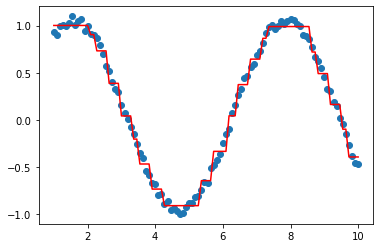

In [284]:
import matplotlib.pyplot as plt
plt.scatter(data, target)
plt.plot(data, tree.predict(data), color='r')

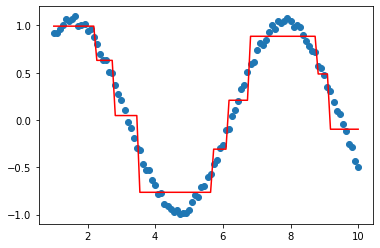

In [280]:
tree.prune(0.5)
plt.scatter(data, target)
plt.plot(data, tree.predict(data), color='r')